Convolutional neural networks based on dogs-and-cats dataset.
More comments right down below :)

In [33]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!curl -o cats-and-dogs.zip "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  436k    0     0   991k      0  0:13:32 --:--:--  0:13:32 1015k
  0  786M    0 5749k    0     0  3992k      0  0:03:21  0:00:01  0:03:20 4020k
  1  786M    1 11.5M    0     0  4860k      0  0:02:45  0:00:02  0:02:43 4880k
  2  786M    2 16.7M    0     0  4993k      0  0:02:41  0:00:03  0:02:38 5008k
  2  786M    2 22.4M    0     0  5148k      0  0:02:36  0:00:04  0:02:32 5160k
  3  786M    3 27.9M    0     0  5253k      0  0:02:33  0:00:05  0:02:28 5629k
  4  786M    4 32.4M    0     0  5159k      0  0:02:36  0:00:06  0:02:30 5495k
  4  786M    4 38.2M    0     0  5261k      0  0:02:33  0:00:07  0:02:26 5457k
  5  786M    5 43.6M    0     0  5289k      0  0:02:32  0:00:08  0:02:24 5494k
  6  786M    6 49.8M    0     0  5407k      0  0:02

In [4]:
def get_valid(file_path):
    correct_files=[]
    for name in os.listdir(file_path):
        try:
            img=Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

I am unpacking the file, two pictures are damaged so i have to delete it.

Next step is to divide the dataset on train, test and validation dataset.
Validation dataset answers on question - when should we stop with training our model(EarlyStopping)

In [5]:
local_zip = './cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'

original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)

random.seed(101)
random.shuffle(original_cat)
random.shuffle(original_dog)

size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'

index=0
for name_cat, name_dog in zip(original_cat, original_dog):
    if index <= train_size:
        type_of_dataset = 'train'
    elif train_size < index <= (train_size + valid_size):
        type_of_dataset = 'valid'
    elif (train_size +valid_size) < index <= (train_size +valid_size +test_size):
        type_of_dataset = 'test'
    shutil.copyfile(src=(original_cat_path + '/' + name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
    shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
    index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


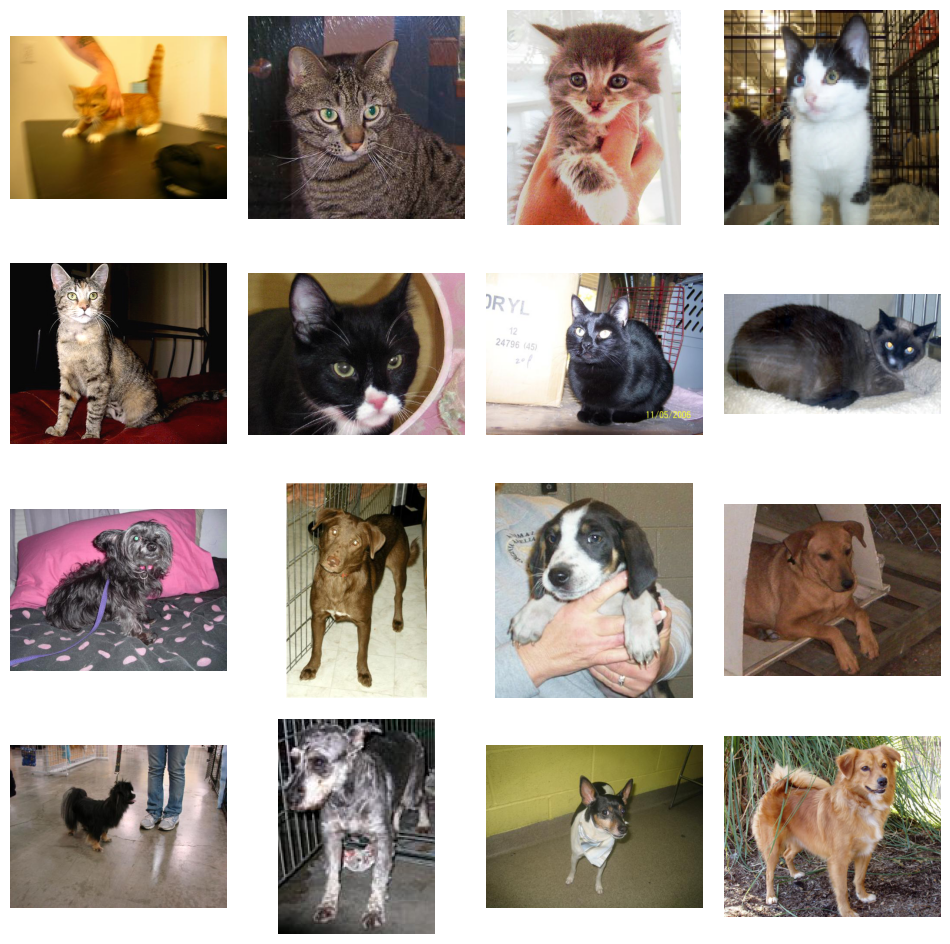

In [6]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Lets start with training the model:
I have indicated the sources for files, the size of the input image, the patience for Early stopping, and the data preparation. Each image is standardized by dividing by 255, since pixels have a value from 0 to 255. In addition, augmentation is also applied to the training set.

In [7]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


Let's create a list to which i will add the names of models and catalogs to which i will save the charts and spreadsheets with the evaluation

In [8]:
models = []
os.mkdir("history")
os.mkdir("charts")

This is first model. Activation layer is relu and output layer is sigmoid. For the metrics i chose accuracy. To shorten the time i used RMSprop. The goal is to classify so i chose binary cross entropy as loss function.

In [9]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss = 'binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [11]:
history_baseline = model_baseline.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.4996 - loss: 1.1246 - val_accuracy: 0.5216 - val_loss: 0.7414
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 94s 696ms/step - accuracy: 0.5189 - loss: 0.9160 - val_accuracy: 0.5120 - val_loss: 0.8969
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.5630 - loss: 0.7338 - val_accuracy: 0.4976 - val_loss: 0.9919
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 505ms/step - accuracy: 0.5170 - loss: 0.9470 - val_accuracy: 0.5104 - val_loss: 0.9127
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 59s 437ms/step - accuracy: 0.5342 - loss: 0.8898 - val_accuracy: 0.5477 - val_loss: 0.7397
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.5076 - loss: 0.7347 - val_accuracy: 0.5292 - val_loss: 0.8033
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 49s 360ms/step - accuracy: 0.5196 - loss: 0.9125 - val_accuracy: 0.5349 - val_loss: 0.7580
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 48s 352ms/step - accuracy: 0.

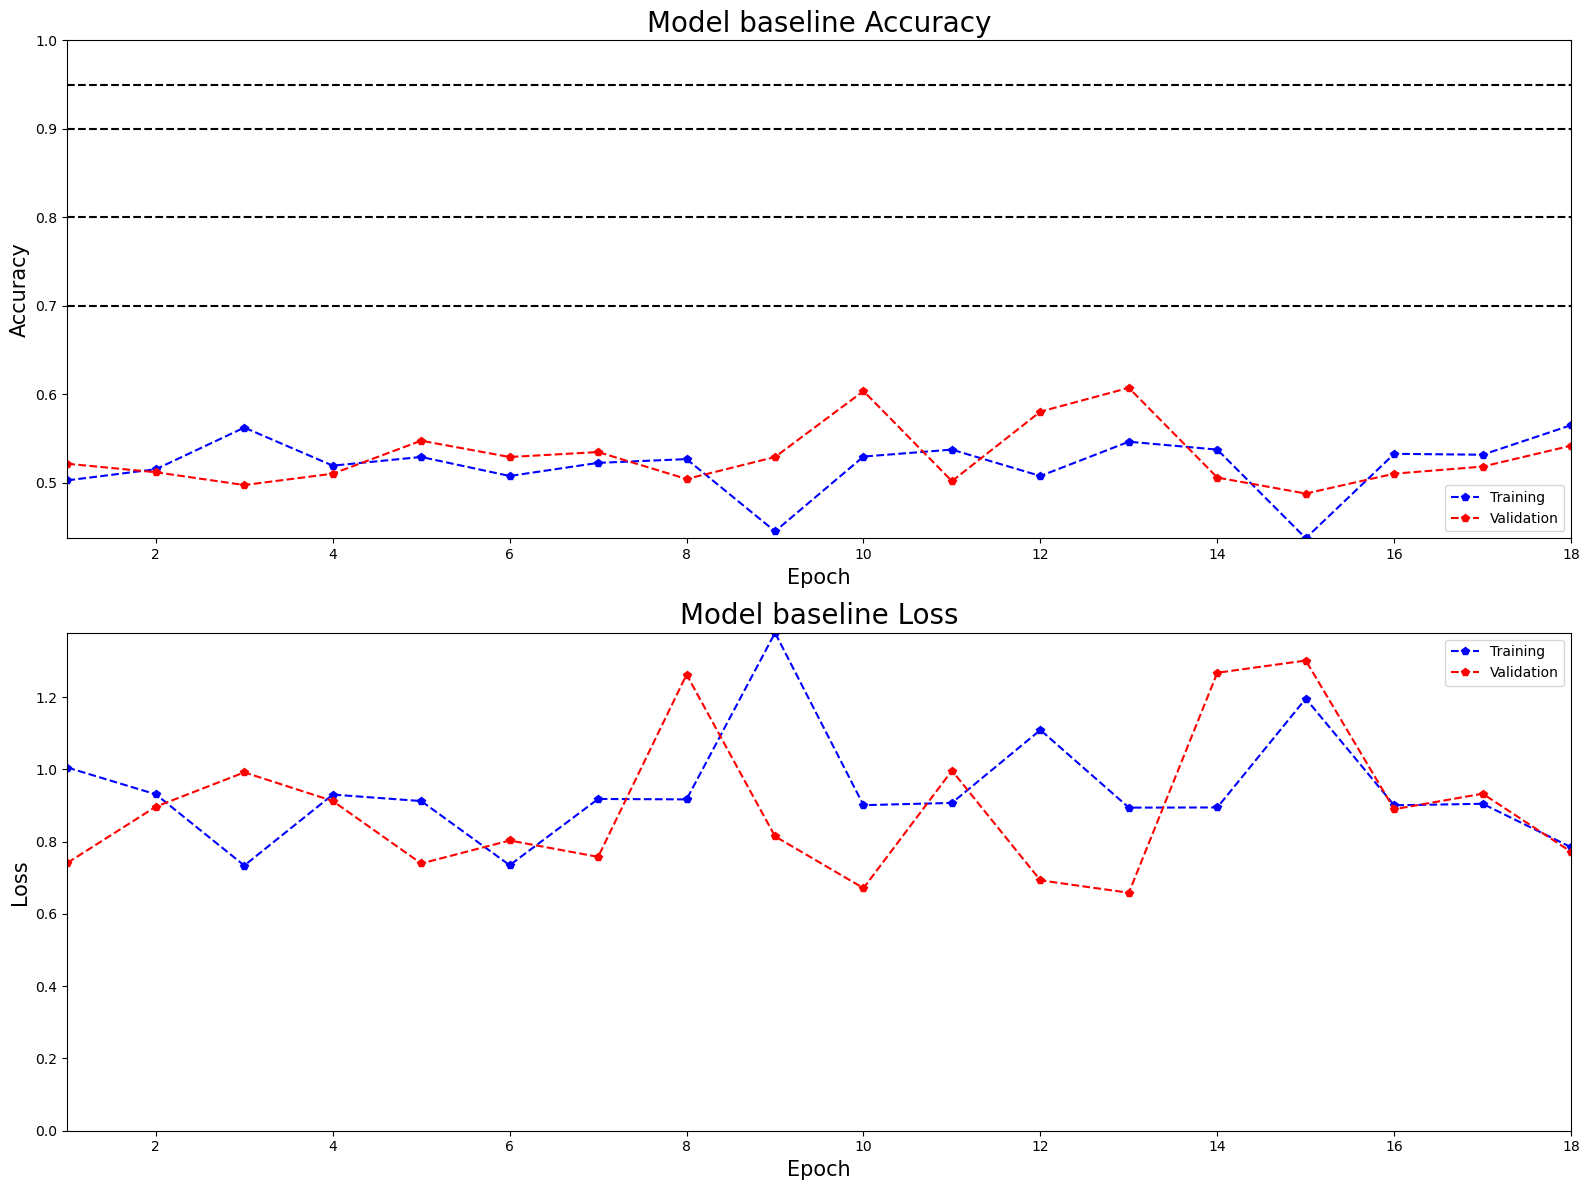

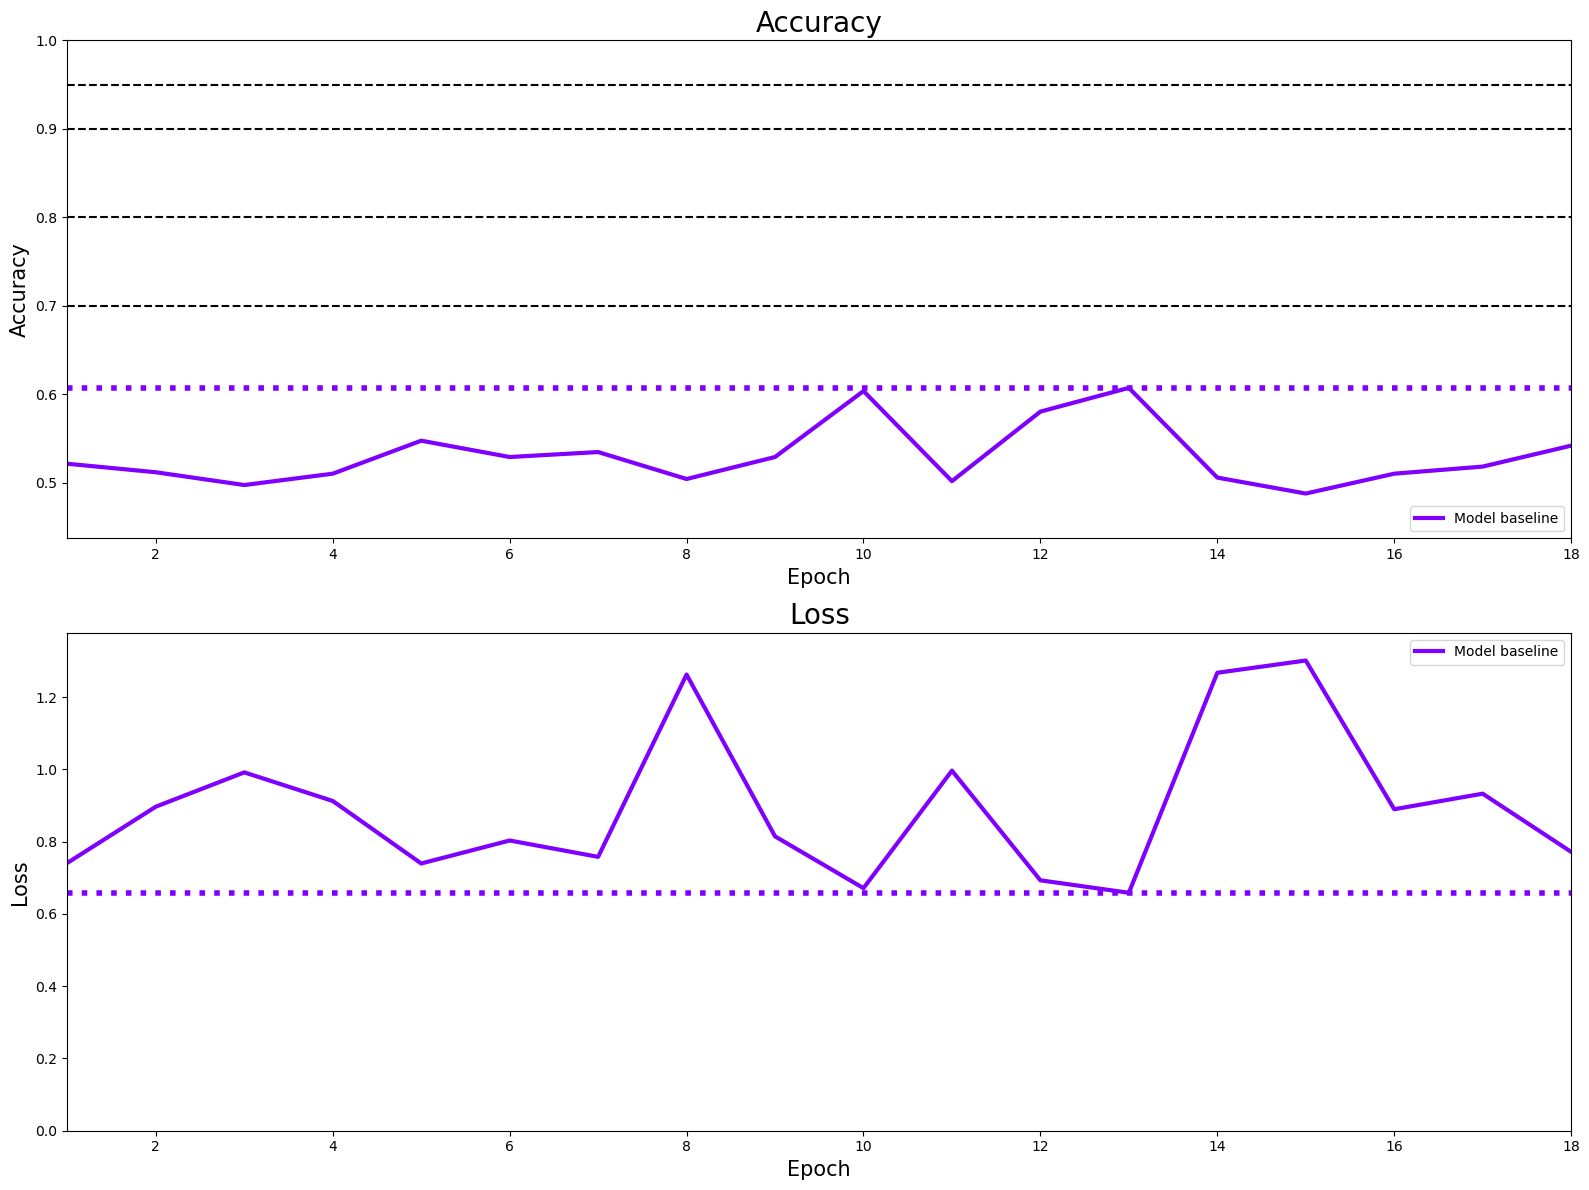

In [12]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index +=1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)

    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")

    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)

plt.show()

The model is mismatched.

It s time for second model. This is easy model of convolutional network with one conv layer and one connecting layer. 

In [13]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 54760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          54,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 54s 382ms/step - accuracy: 0.5516 - loss: 0.8487 - val_accuracy: 0.6887 - val_loss: 0.5930
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 56s 415ms/step - accuracy: 0.6889 - loss: 0.5814 - val_accuracy: 0.7083 - val_loss: 0.5691
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7266 - loss: 0.5705 - val_accuracy: 0.7047 - val_loss: 0.5741
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 52s 383ms/step - accuracy: 0.7405 - loss: 0.5238 - val_accuracy: 0.7216 - val_loss: 0.5599
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 54s 401ms/step - accuracy: 0.7678 - loss: 0.4921 - val_accuracy: 0.7296 - val_loss: 0.5324
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7105 - loss: 0.5293 - val_accuracy: 0.7276 - val_loss: 0.5294
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 49s 356ms/step - accuracy: 0.7897 - loss: 0.4663 - val_accuracy: 0.7332 - val_loss: 0.5428
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 50s 372ms/step - accuracy: 0.

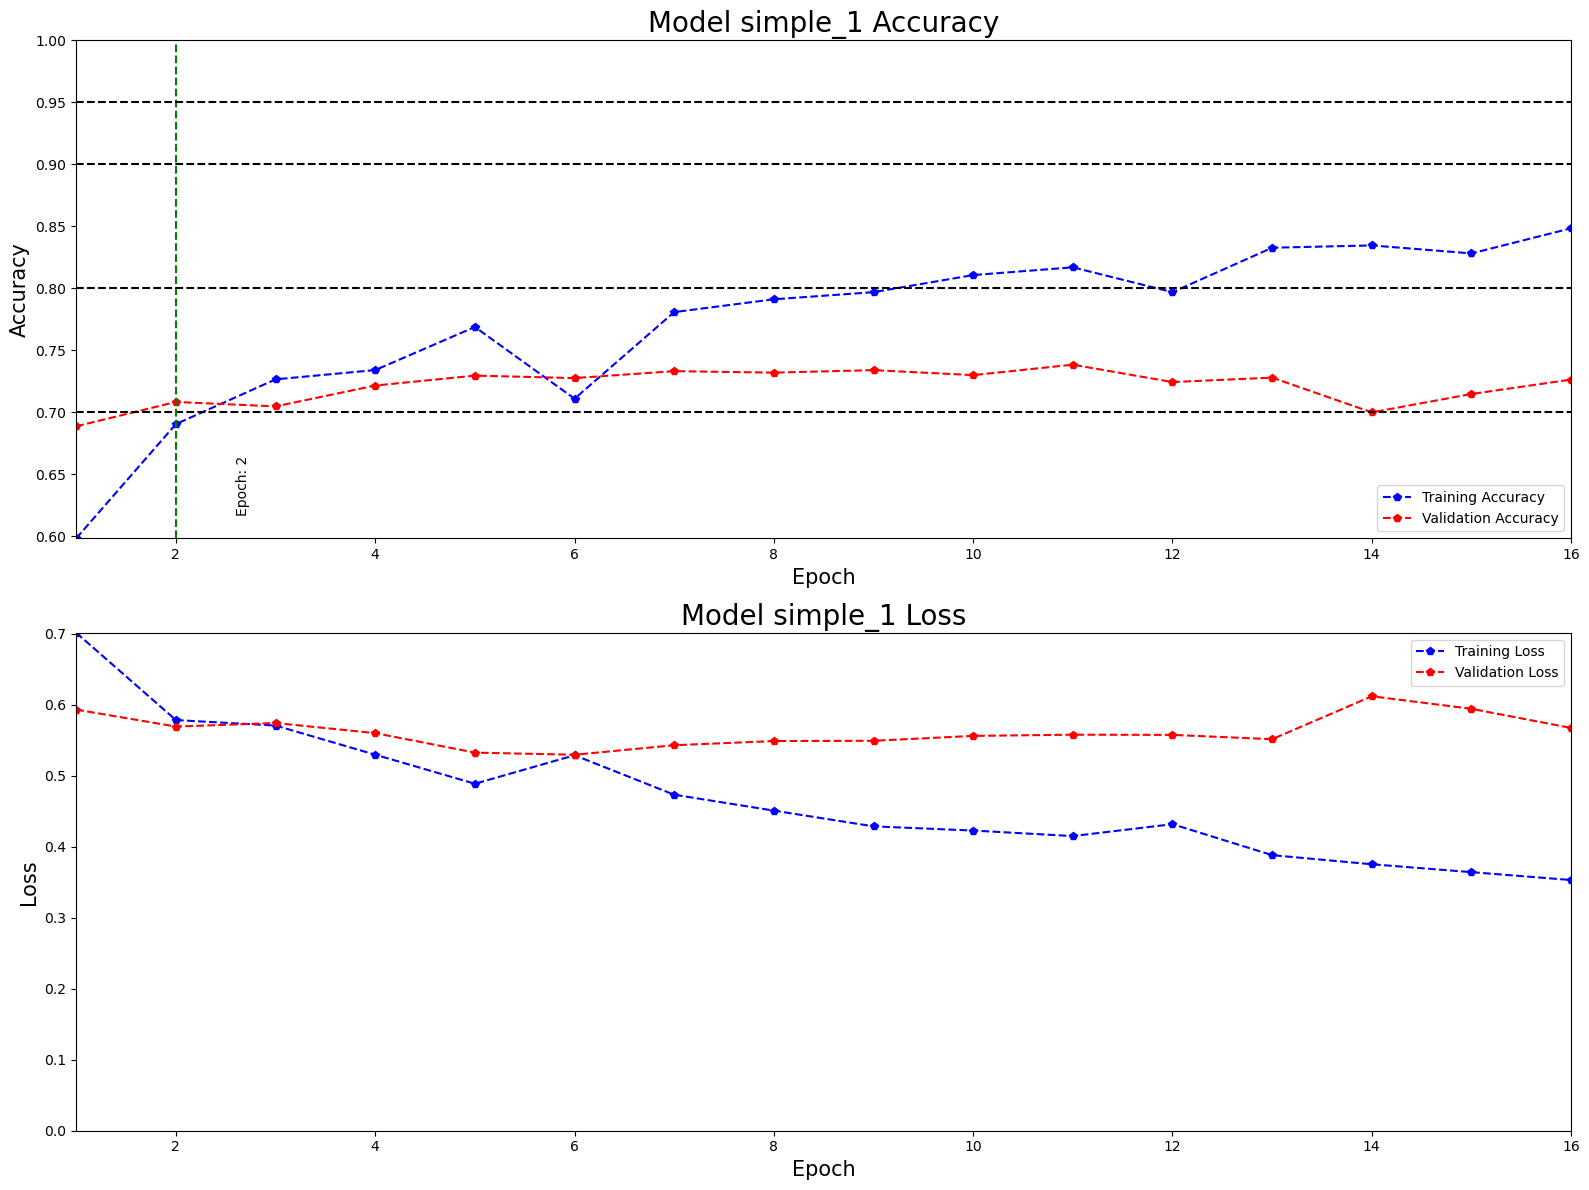

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('history/history_simple_1.csv', index_col=0)
df.index += 1 

max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model simple_1 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])

for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')

ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model simple_1 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'charts/train_history_simple_1.png', transparent=True, dpi=600)
plt.show()

This model has fewer parameters, but that's because a convolution layer is used. The further the epoch, the difference between the training and validation sets becomes larger, which is a sign of overfitting. 

This is third model. During the convolution operation, the side pixels are removed, which causes a loss of information. This can be avoided if the input image is surrounded by pixels. In this model, this is exploited using padding.

In [16]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          56,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 60s 426ms/step - accuracy: 0.5398 - loss: 0.9511 - val_accuracy: 0.6102 - val_loss: 0.6471
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 62s 454ms/step - accuracy: 0.6865 - loss: 0.5968 - val_accuracy: 0.6879 - val_loss: 0.5859
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7031 - loss: 0.6032 - val_accuracy: 0.7083 - val_loss: 0.5867
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 56s 409ms/step - accuracy: 0.7275 - loss: 0.5543 - val_accuracy: 0.7095 - val_loss: 0.5771
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 57s 421ms/step - accuracy: 0.7533 - loss: 0.5114 - val_accuracy: 0.7163 - val_loss: 0.5693
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7265 - loss: 0.4990 - val_accuracy: 0.7007 - val_loss: 0.5909
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 55s 407ms/step - accuracy: 0.7733 - loss: 0.4834 - val_accuracy: 0.7356 - val_loss: 0.5290
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/step - accuracy: 0.

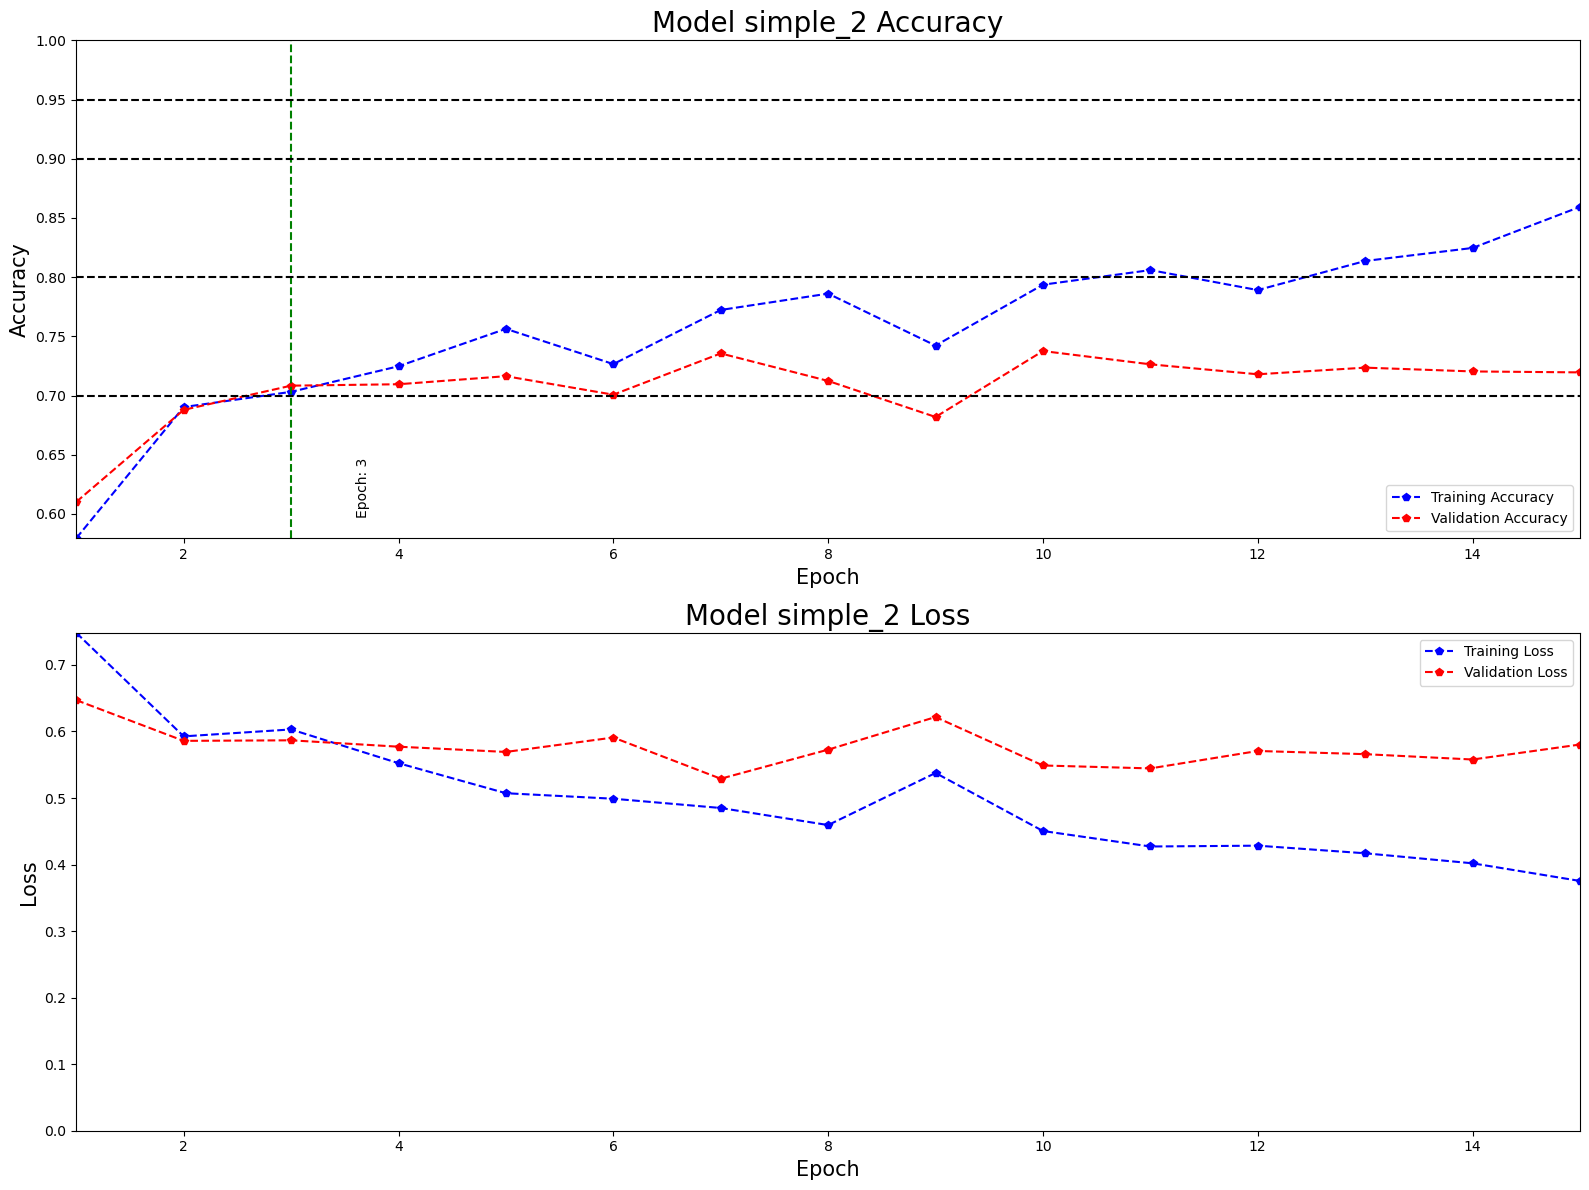

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('history/history_simple_2.csv', index_col=0)
df.index += 1  

max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model simple_2 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])

for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')

ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model simple_2 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'charts/train_history_simple_2.png', transparent=True, dpi=600)
plt.show()

In this model overfitting is more noticeable.

Lets make our model more complicated and check if adding more convolutional layers or pooling bring us better accuracy. But the more parameters the bigger probablity of overfitting.

In [19]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_model_1 = model_1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.5108 - loss: 0.6892 - val_accuracy: 0.6110 - val_loss: 0.6563
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5990 - loss: 0.6523 - val_accuracy: 0.6298 - val_loss: 0.6335
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.6094 - loss: 0.6313 - val_accuracy: 0.6226 - val_loss: 0.6435
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.6252 - loss: 0.6324 - val_accuracy: 0.6294 - val_loss: 0.6247
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.6765 - loss: 0.5967 - val_accuracy: 0.6863 - val_loss: 0.5870
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7032 - loss: 0.5636 - val_accuracy: 0.7015 - val_loss: 0.5602
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7171 - loss: 0.5537 - val_accuracy: 0.7292 - val_loss: 0.5401
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.7114 - los

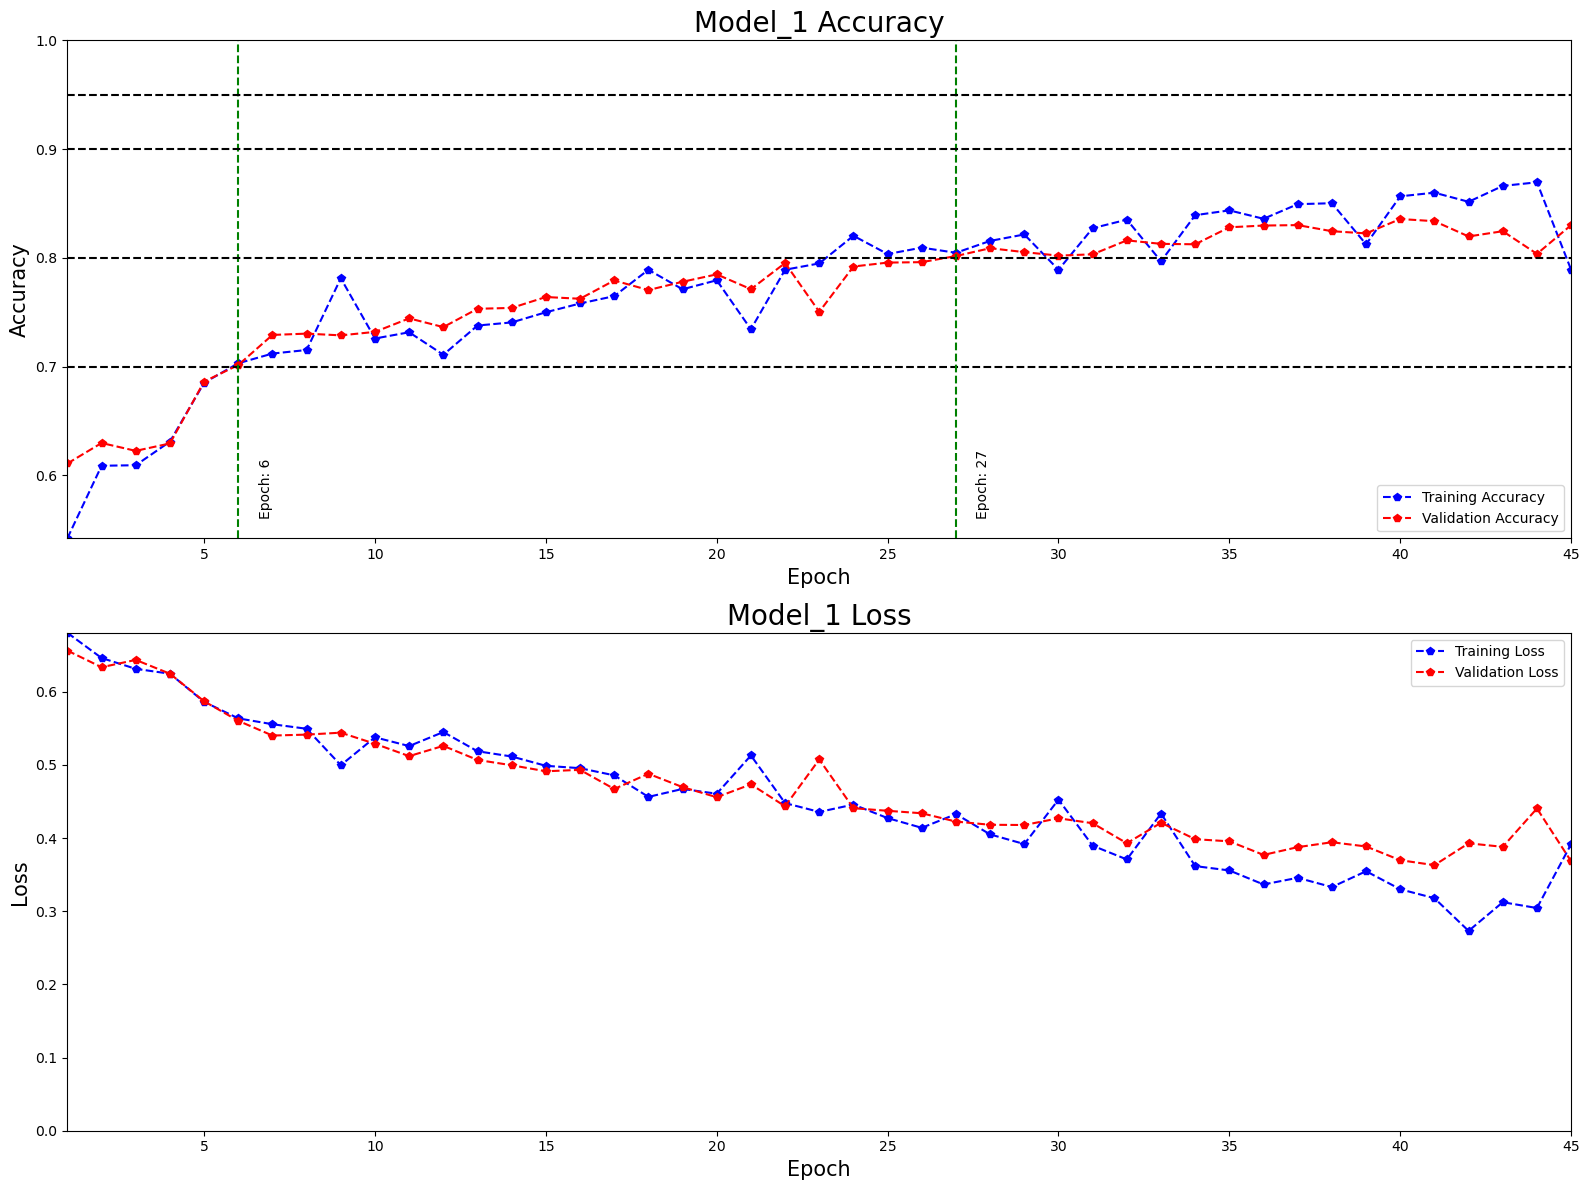

In [21]:
df = pd.read_csv('history/history_model_1.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_1 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_1 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_1.png', transparent=True, dpi=600)
plt.show()

Each model gives us better results. 

I want to continue teaching. Lets use regularization and start from Dropout.

In [22]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_2.summary()
models.append("model_2")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_model_2 = model_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

history_model_2_df = pd.DataFrame(history_model_2.history)
history_model_2_csv_file = 'history/history_model_2.csv'

with open(history_model_2_csv_file, mode='w') as f:
    history_model_2_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.5004 - loss: 0.6929 - val_accuracy: 0.5188 - val_loss: 0.6870
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.5569 - loss: 0.6776 - val_accuracy: 0.5573 - val_loss: 0.6893
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.5625 - loss: 0.6860 - val_accuracy: 0.6278 - val_loss: 0.6454
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5999 - loss: 0.6486 - val_accuracy: 0.6406 - val_loss: 0.6343
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6085 - loss: 0.6436 - val_accuracy: 0.6402 - val_loss: 0.6112
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.5854 - loss: 0.6778 - val_accuracy: 0.6222 - val_loss: 0.6380
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.6442 - loss: 0.6203 - val_accuracy: 0.6799 - val_loss: 0.5930
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6672 - los

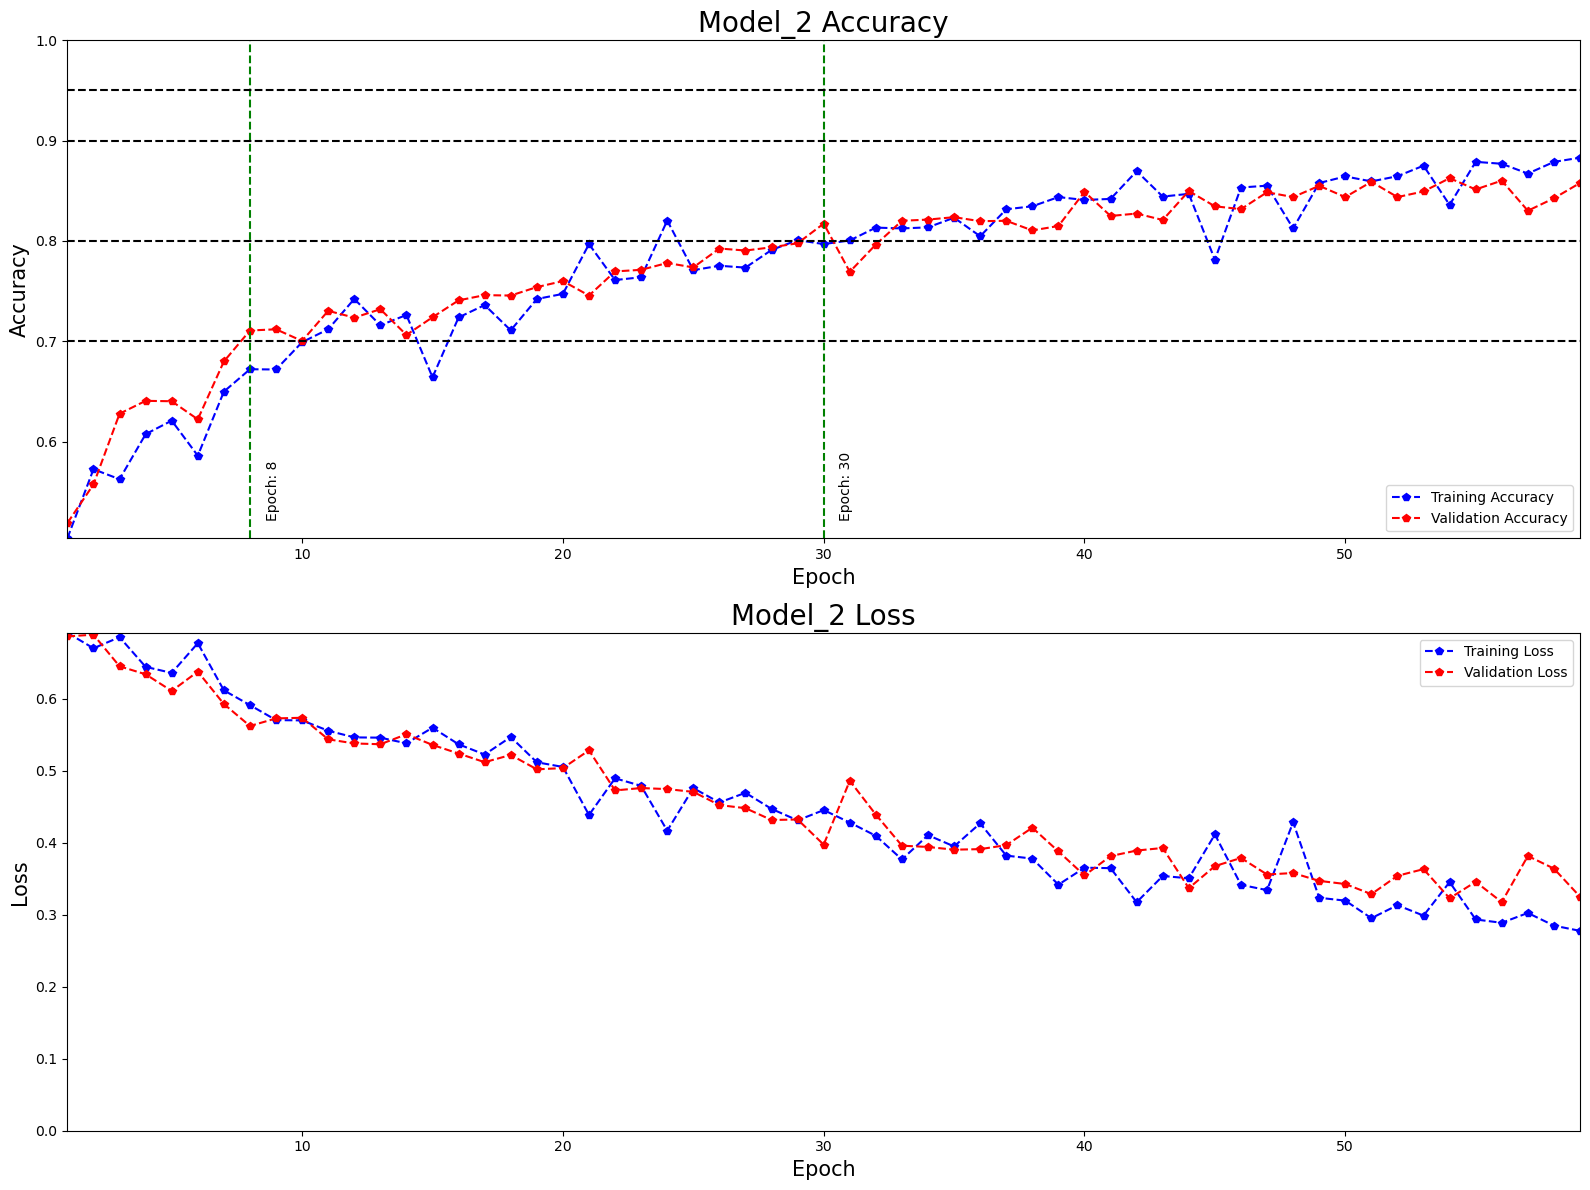

In [24]:
df = pd.read_csv('history/history_model_2.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_2 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_2 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_2.png', transparent=True, dpi=600)
plt.show()

The accuracy is much higher than in previous model.

Despite the use of the dropout technique, the model in the final phase does not learn generalized patterns, but rather over-learns and learns images from the training set. Now we will extend the training set by data augmentation.

In [25]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_model_3 = model_3.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.5063 - loss: 0.6926 - val_accuracy: 0.5593 - val_loss: 0.6913
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.5272 - val_loss: 0.6870
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.5072 - loss: 0.6937 - val_accuracy: 0.5084 - val_loss: 0.6879
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.5563 - loss: 0.6872 - val_accuracy: 0.6170 - val_loss: 0.6606
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - accuracy: 0.5897 - loss: 0.6725 - val_accuracy: 0.5841 - val_loss: 0.6716
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.5785 - loss: 0.6522 - val_accuracy: 0.6322 - val_loss: 0.6419
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.6072 - loss: 0.6588 - val_accuracy: 0.6166 - val_loss: 0.6535
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.6233 - los

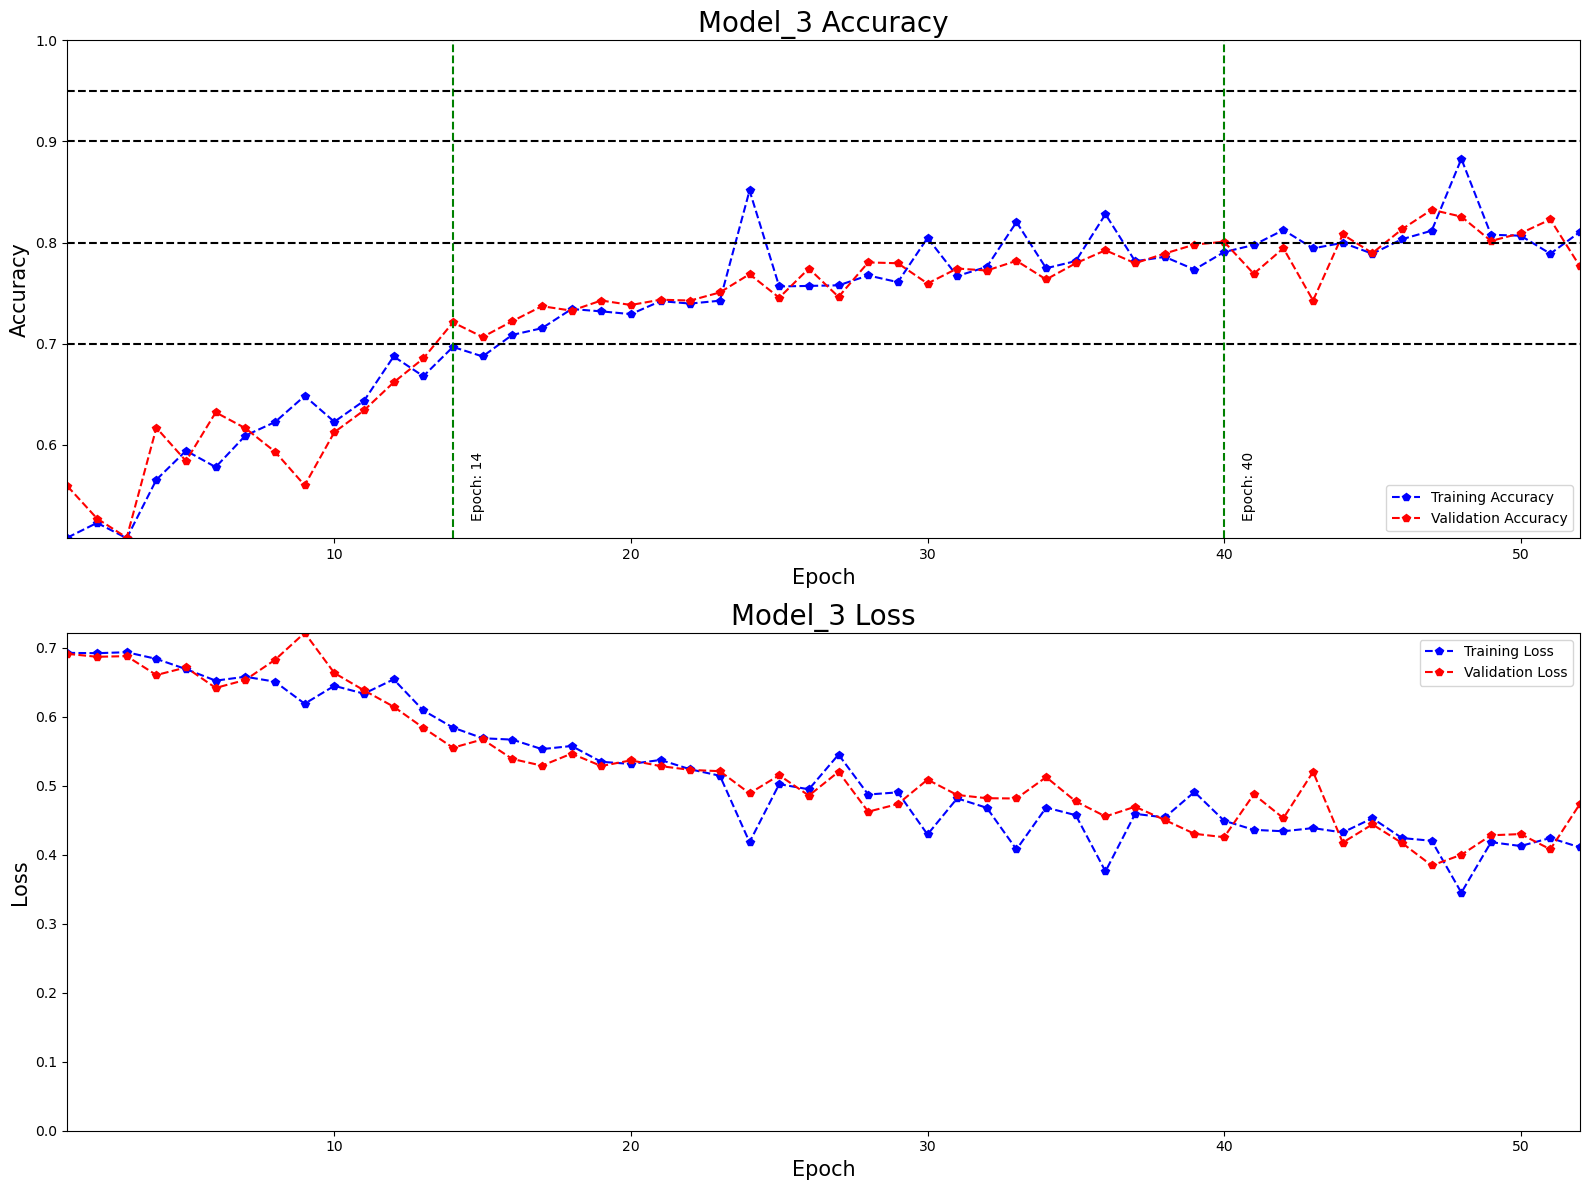

In [27]:
df = pd.read_csv('history/history_model_3.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_3 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_3 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_3.png', transparent=True, dpi=600)
plt.show()

The results often are better for validation set because of using different training sets. I used another technique of regularization and because of that learning time is extended. Nevertheless the results are better again. I think adding more 'blocks' improved the quality of the model, when we compare this model to first trained network. 

The last 'block' is adding transfer learning. As a base i will use VGG16 which was trained on the ImageNet dataset(over 14 milion images with 20 thousand classes). The last three conv layers and fully connected layers are trained. I will also use regularization as Dropout and data augmentation. 

In [28]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

layer_name: input_layer_6 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [29]:
history_model_4 = model_4.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2654s 20s/step - accuracy: 0.7101 - loss: 0.5451 - val_accuracy: 0.9279 - val_loss: 0.1855
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2668s 20s/step - accuracy: 0.8863 - loss: 0.2749 - val_accuracy: 0.9375 - val_loss: 0.1670
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.8517 - loss: 0.3286 - val_accuracy: 0.8830 - val_loss: 0.2742
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1717s 13s/step - accuracy: 0.9076 - loss: 0.2271 - val_accuracy: 0.9459 - val_loss: 0.1448
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2332s 17s/step - accuracy: 0.9032 - loss: 0.2143 - val_accuracy: 0.9419 - val_loss: 0.1918
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.9221 - loss: 0.1600 - val_accuracy: 0.9459 - val_loss: 0.1537
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2547s 19s/step - accuracy: 0.9232 - loss: 0.1860 - val_accuracy: 0.9467 - val_loss: 0.1580
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2123s 16s/step - accuracy: 0.92

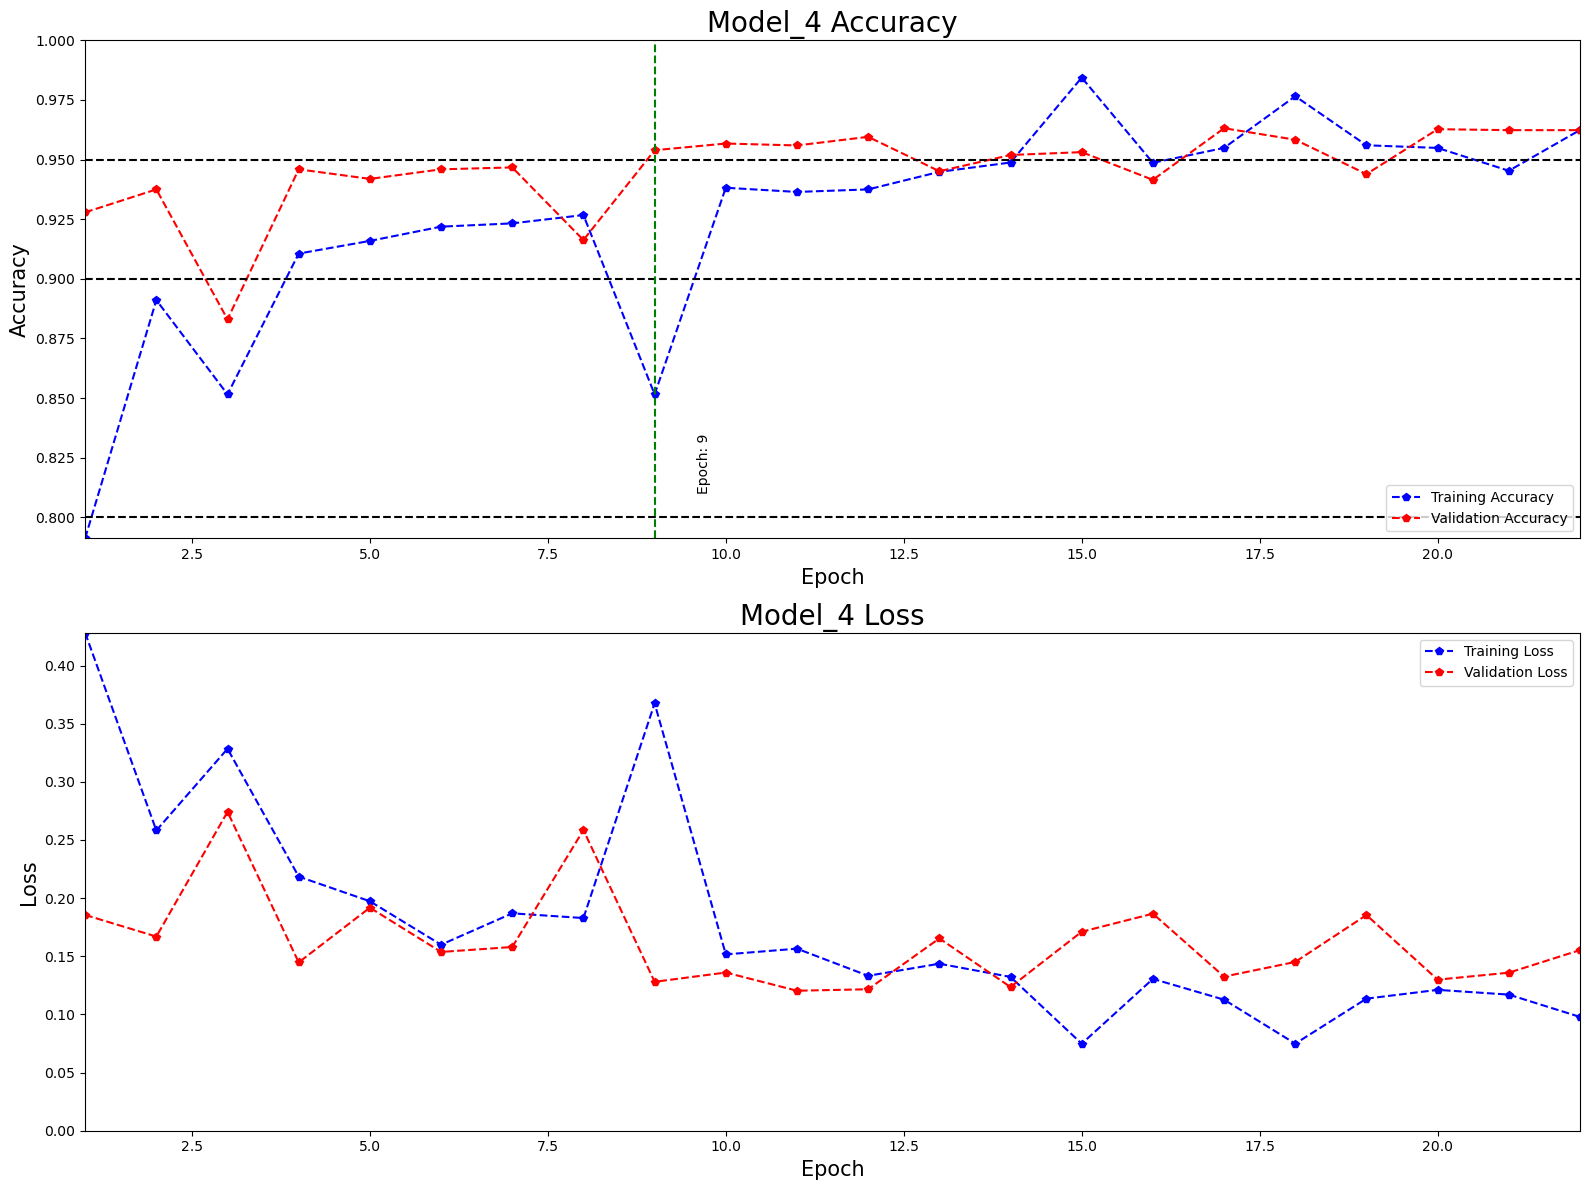

In [30]:
df = pd.read_csv('history/history_model_4.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_4 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_4 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_4.png', transparent=True, dpi=600)
plt.show()

This model has same advantages as previous one, and what is important this model didn't learn from the beginning. The model achieved accuracy 90% in fourth epoch.

Lets check each model results on validation set.

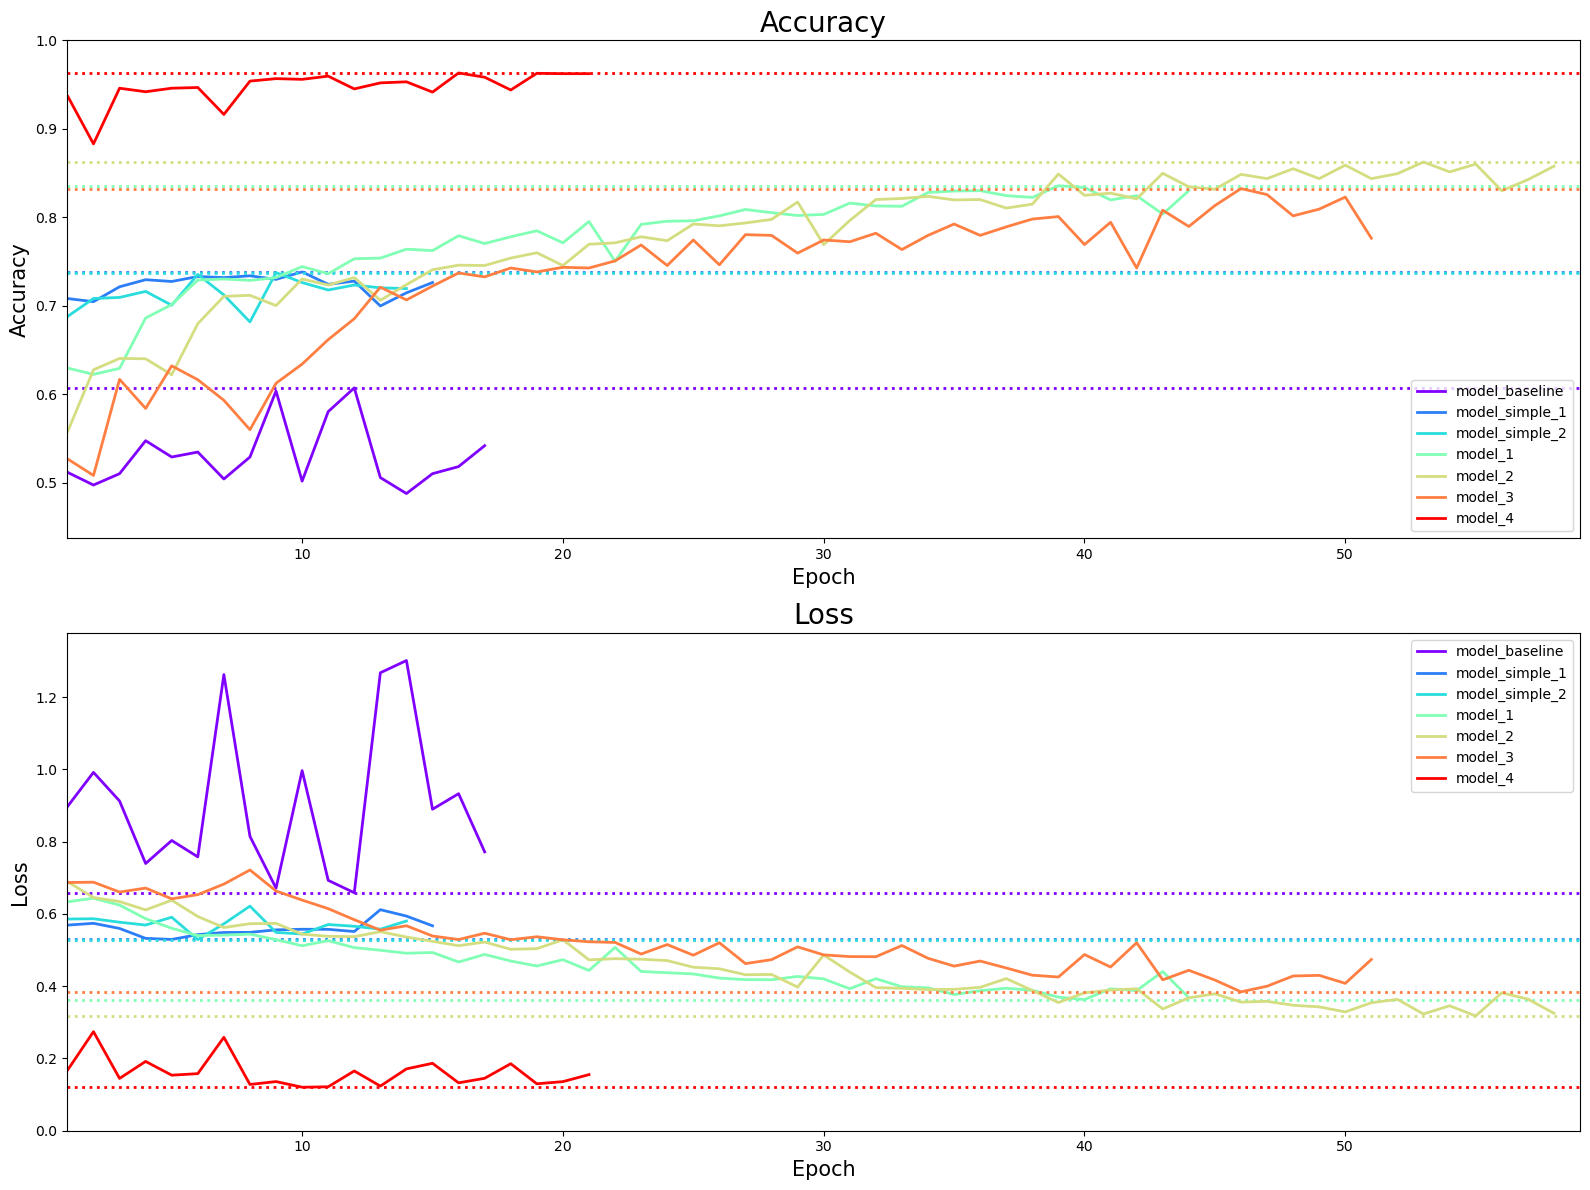

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

models = ["model_baseline", "model_simple_1", "model_simple_2", "model_1", "model_2", "model_3", "model_4"]
file_mapping = {
    "model_baseline": "history_baseline.csv",
    "model_simple_1": "history_simple_1.csv",
    "model_simple_2": "history_simple_2.csv",
    "model_1": "history_model_1.csv",
    "model_2": "history_model_2.csv",
    "model_3": "history_model_3.csv",
    "model_4": "history_model_4.csv",
}


colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))


max_epoch = 0
min_acc = 1
max_loss = 0


for model in models:
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    max_epoch = max(max_epoch, len(df))
    min_acc = min(min_acc, df[['accuracy', 'val_accuracy']].min().min())
    max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())


fig, axes = plt.subplots(2, 1, figsize=(16, 12))


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[0].plot(df['val_accuracy'], label=f'{model}', color=color, linewidth=2)
    axes[0].axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=2)

axes[0].set_title('Accuracy', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_xlim([1, max_epoch])
axes[0].set_ylim([min_acc, 1])
axes[0].legend(loc='lower right')


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[1].plot(df['val_loss'], label=f'{model}', color=color, linewidth=2)
    axes[1].axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=2)

axes[1].set_title('Loss', fontsize=20)
axes[1].set_ylabel('Loss', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_xlim([1, max_epoch])
axes[1].set_ylim([0, max_loss])
axes[1].legend(loc='upper right')


plt.tight_layout()
plt.savefig('charts/comparison_accuracy_loss.png', dpi=600)
plt.show()


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "dataset/test"


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary',  
    shuffle=False  
)


Found 2500 images belonging to 2 classes.


In [34]:
model_objects = {
    "model_baseline": model_baseline,
    "model_simple_1": model_simple_1,
    "model_simple_2": model_simple_2,
    "model_1": model_1,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
}

for model_name, model in model_objects.items():

    predictions = (model.predict(test_generator) > 0.5).astype("int32")
    true_labels = test_generator.classes

    report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
    print(f"Classification Report for {model_name}:\n")
    print(report)


79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 442ms/step
Classification Report for model_baseline:

              precision    recall  f1-score   support

         Cat       0.64      0.54      0.59      1250
         Dog       0.60      0.69      0.64      1250

    accuracy                           0.62      2500
   macro avg       0.62      0.62      0.61      2500
weighted avg       0.62      0.62      0.61      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step
Classification Report for model_simple_1:

              precision    recall  f1-score   support

         Cat       0.75      0.69      0.72      1250
         Dog       0.71      0.77      0.74      1250

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step
Classification Report for model_simple_2:

              precision    recall  f1-score   support

         Cat       0.77      0.68   

Trained models achieved very satisfying classification scores on test set. I added augmentation to expand the dataset. Dropout causes that every neuron is important. The network learns what is important to classify right and choose patterns. Kernel helps to recognize right patterns. The network parameters are values in filters. If there is a more than two-dimensional object in front of the convolution layer, the filter is a cube with depth 3 for RGB images or equal to the number of filters in the previous layer. Activation layer is usually ReLU. For information aggregation responsible is pooling layer. Multilayer networks alternately use convolution and pooling layers. At the beginning, the networks detect simple features, and in the later layers, they detect complex features. I used Transfer learning. Filters responsible for recognizing basic features were frozen. The last layers and hidden layers were trained to use the network for a specific problem. Regularization is a way to avoid overfitting. Additionally, it has a positive effect on the accuracy of the network.

I trained one more model to check if adding more conv layers improve accuracy. 

In [35]:
model_5 = Sequential()

# Block 1
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_5.add(Dense(units=1, activation='sigmoid'))


model_5.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
model_5.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,177,089 (12.12 MB)

 Trainable params: 3,177,089 (12.12 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_model_5 = model_5.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_5_df = pd.DataFrame(history_model_5.history)
history_model_5_csv_file = 'history/history_model_5.csv'
with open(history_model_5_csv_file, mode='w') as f:
    history_model_5_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - accuracy: 0.5091 - loss: 1.6641 - val_accuracy: 0.5617 - val_loss: 1.5500
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 650s 5s/step - accuracy: 0.5094 - loss: 1.5156 - val_accuracy: 0.5036 - val_loss: 1.4188
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.4293 - loss: 1.4188 - val_accuracy: 0.5068 - val_loss: 1.4169
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 670s 5s/step - accuracy: 0.5070 - loss: 1.3879 - val_accuracy: 0.5076 - val_loss: 1.3056
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 598s 4s/step - accuracy: 0.5115 - loss: 1.2810 - val_accuracy: 0.5024 - val_loss: 1.2108
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.5391 - loss: 1.2102 - val_accuracy: 0.4924 - val_loss: 1.2099


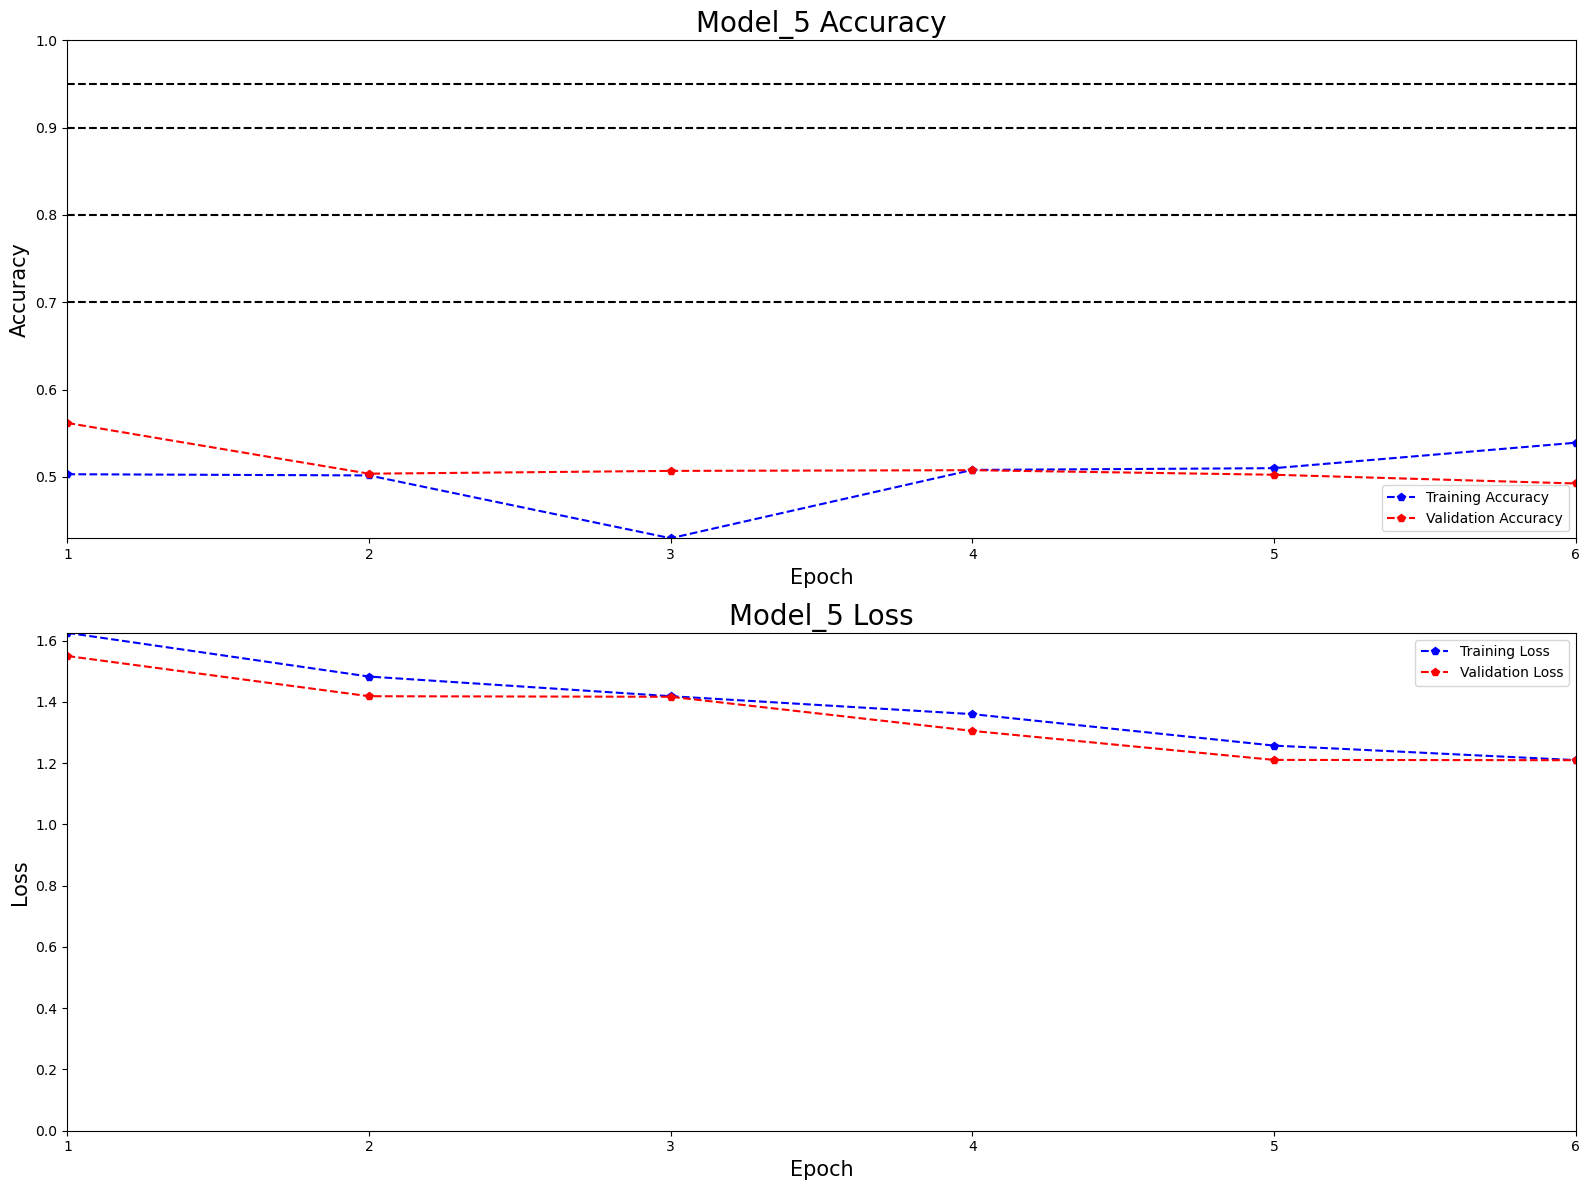

In [37]:
df = pd.read_csv('history/history_model_5.csv', index_col=0)
df.index += 1  


max_index = max(df.index)
min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
max_loss = max(df[['loss', 'val_loss']].max())

fig = plt.figure(figsize=(16, 12))


ax = fig.add_subplot(211)
ax.plot(df['accuracy'], "bp--", label='Training Accuracy')
ax.plot(df['val_accuracy'], "rp--", label='Validation Accuracy')
ax.set_title(f'Model_5 Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])


for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
    try:
        if min(df[df['val_accuracy'] >= milestone].index) > 1:
            ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
            ax.text(min(df[df["val_accuracy"] >= milestone].index) + 0.6, min_accuracy + 0.02,
                    f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
    except:
        pass

ax.legend(loc='lower right')


ax = fig.add_subplot(212)
ax.plot(df['loss'], "bp--", label='Training Loss')
ax.plot(df['val_loss'], "rp--", label='Validation Loss')
ax.set_title(f'Model_5 Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig(f'charts/train_history_model_5.png', transparent=True, dpi=600)
plt.show()

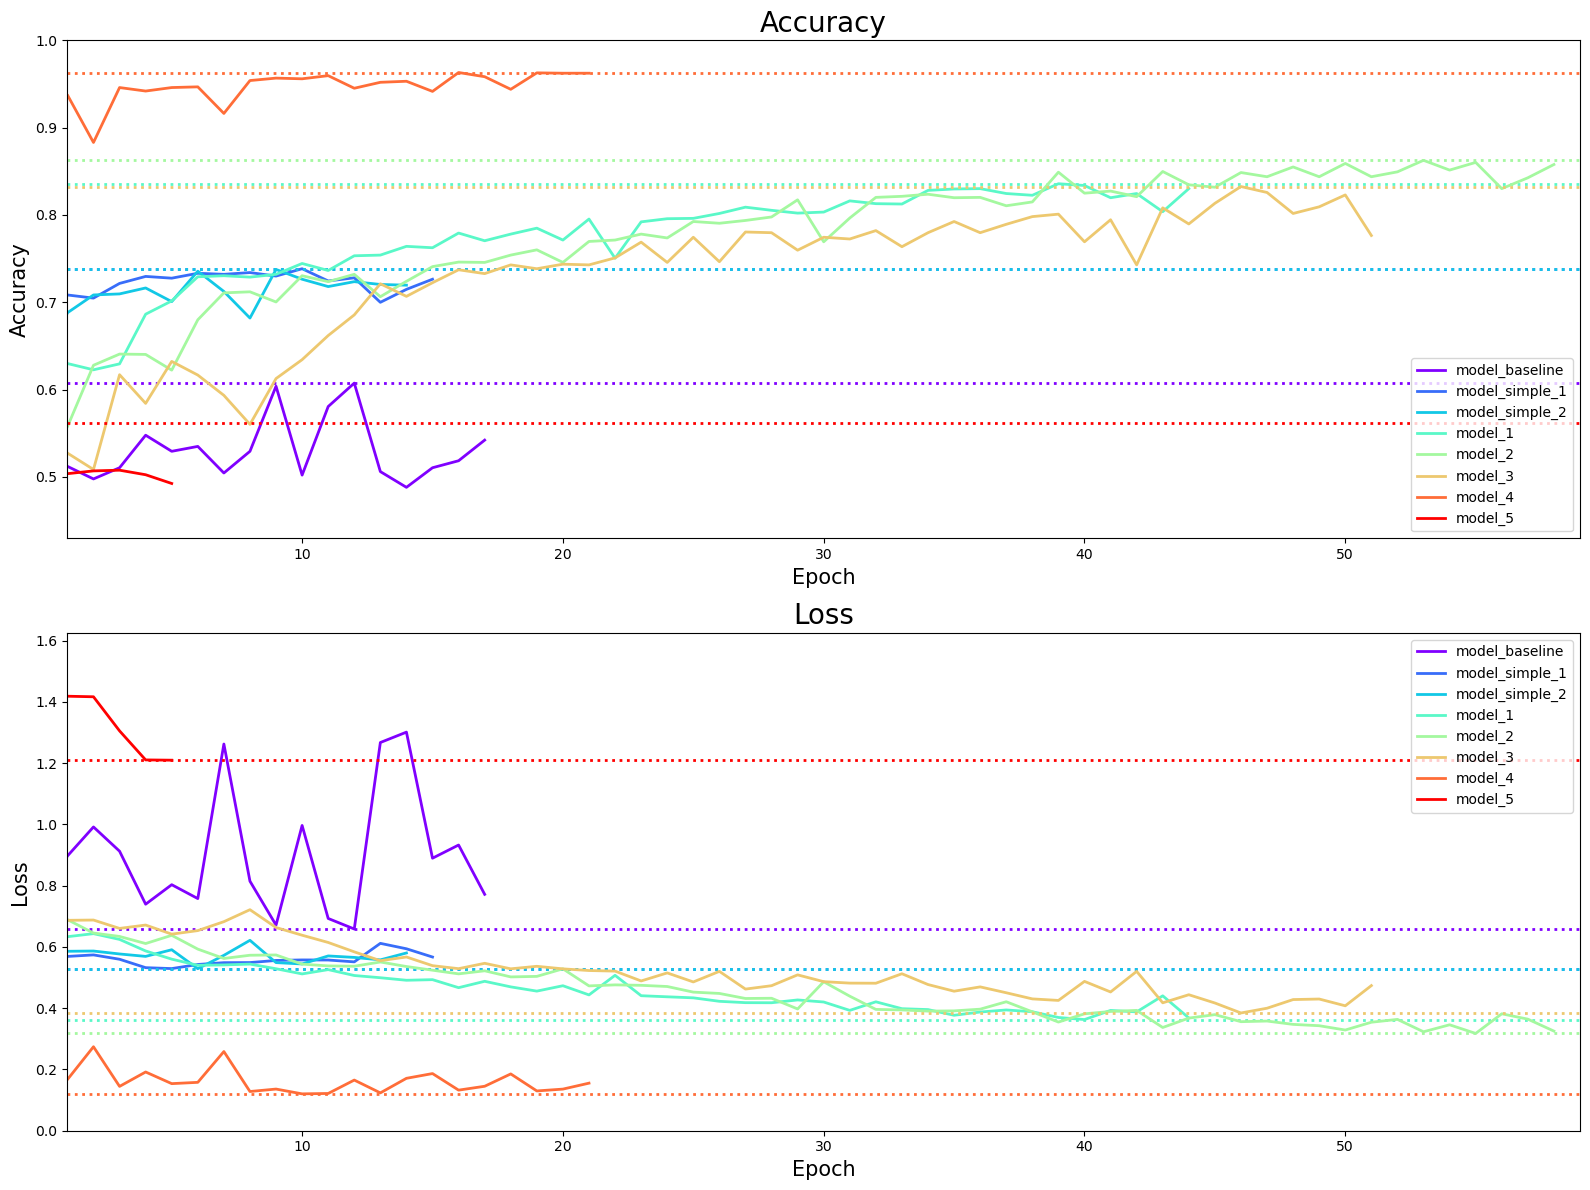

In [38]:
models = ["model_baseline", "model_simple_1", "model_simple_2", "model_1", "model_2", "model_3", "model_4", "model_5"]
file_mapping = {
    "model_baseline": "history_baseline.csv",
    "model_simple_1": "history_simple_1.csv",
    "model_simple_2": "history_simple_2.csv",
    "model_1": "history_model_1.csv",
    "model_2": "history_model_2.csv",
    "model_3": "history_model_3.csv",
    "model_4": "history_model_4.csv",
    "model_5": "history_model_5.csv",
}


colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))


max_epoch = 0
min_acc = 1
max_loss = 0


for model in models:
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    max_epoch = max(max_epoch, len(df))
    min_acc = min(min_acc, df[['accuracy', 'val_accuracy']].min().min())
    max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())


fig, axes = plt.subplots(2, 1, figsize=(16, 12))


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[0].plot(df['val_accuracy'], label=f'{model}', color=color, linewidth=2)
    axes[0].axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=2)

axes[0].set_title('Accuracy', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_xlim([1, max_epoch])
axes[0].set_ylim([min_acc, 1])
axes[0].legend(loc='lower right')


for model, color in zip(models, colors):
    file = f"history/{file_mapping[model]}"
    df = pd.read_csv(file, index_col=0)
    axes[1].plot(df['val_loss'], label=f'{model}', color=color, linewidth=2)
    axes[1].axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=2)

axes[1].set_title('Loss', fontsize=20)
axes[1].set_ylabel('Loss', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_xlim([1, max_epoch])
axes[1].set_ylim([0, max_loss])
axes[1].legend(loc='upper right')


plt.tight_layout()
plt.savefig('charts/comparison_accuracy_loss.png', dpi=600)
plt.show()


In [39]:
model_objects = {
    "model_baseline": model_baseline,
    "model_simple_1": model_simple_1,
    "model_simple_2": model_simple_2,
    "model_1": model_1,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
    "model_5": model_5,
}

for model_name, model in model_objects.items():

    predictions = (model.predict(test_generator) > 0.5).astype("int32")
    true_labels = test_generator.classes

    report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
    print(f"Classification Report for {model_name}:\n")
    print(report)


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step
Classification Report for model_baseline:

              precision    recall  f1-score   support

         Cat       0.64      0.54      0.59      1250
         Dog       0.60      0.69      0.64      1250

    accuracy                           0.62      2500
   macro avg       0.62      0.62      0.61      2500
weighted avg       0.62      0.62      0.61      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step
Classification Report for model_simple_1:

              precision    recall  f1-score   support

         Cat       0.75      0.69      0.72      1250
         Dog       0.71      0.77      0.74      1250

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step
Classification Report for model_simple_2:

              precision    recall  f1-score   support

         Cat       0.77      0.68   

Model 5 is the worst. Low val accuracy which from second epoch started to fall down. The best is model 4 - high accuracy on both training and test set from the beginning, appropriate val loss decrease.